In [1]:
import os
import pyopencl as pcl
import numpy as np
import scipy.stats as ss
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
clfile = os.path.join('..','src','glm_gpu','cl','logistic.cl')
os.path.isfile(clfile)

True

In [43]:
os.environ['PYOPENCL_COMPILER_OUTPUT'] = '1'
device = pcl.get_platforms()[0].get_devices()[2]
cntx = pcl.Context([device])
queue = pcl.CommandQueue(cntx)

with open(clfile, 'r') as f:
    programs = pcl.Program(cntx, f.read()).build()

In [44]:
device.name

'AMD Radeon R9 M370X Compute Engine'

In [45]:
theta = np.array([0.5, 0.5], dtype=np.float32)

In [46]:
theta.dtype

dtype('float32')

In [47]:
x0_1 = ss.norm(loc=10.0, scale=2.0)
x0_0 = ss.norm(loc=7.0, scale=2.0)
x1_1 = ss.norm(loc=5.0, scale=3.0)
x1_0 = ss.norm(loc=-5.0, scale=3.0)

In [48]:
nsamps=2

X_1 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])
X_0 = pd.DataFrame(index=range(nsamps), 
                   columns=['x0','x1', 'y'])

X_1.loc[:, 'x0'] = x0_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'x1'] = x1_1.rvs(size=(nsamps,)).astype(np.float32)
X_1.loc[:, 'y'] = np.ones(shape=(nsamps,)).astype(np.float32)

X_0.loc[:, 'x0'] = x0_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'x1'] = x1_0.rvs(size=(nsamps,)).astype(np.float32)
X_0.loc[:, 'y'] = np.zeros(shape=(nsamps,)).astype(np.float32)


In [49]:
X_all = pd.concat((X_1, X_0), ignore_index=True)

In [50]:
X_all = X_all.reindex(np.random.permutation(X_all.index))

In [51]:
X = X_all.loc[:, ['x0', 'x1']]
y = X_all.loc[:,'y']

In [52]:
X.values

array([[ 13.2335968 ,   4.43416882],
       [  6.71336794,  -1.77869785],
       [  7.12713623,   6.31818056],
       [  8.43808556,  -4.48261213]], dtype=float32)

In [53]:
cost_arr = np.zeros(shape=(X.shape[0],)).astype(np.float32)
temp_avg = np.zeros(shape=(4,)).astype(np.float32)

In [54]:
# compute cost
X_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=X.values)
y_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=y.values)
theta_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=theta)
cost_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_WRITE | pcl.mem_flags.COPY_HOST_PTR, hostbuf=cost_arr)
temp_buf = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY, size=temp_avg.nbytes)
scratch_buf = pcl.LocalMemory(np.float32().nbytes * 256)

nrows = np.int32(X.shape[0])
ncols = np.int32(X.shape[1])

out = np.zeros(shape=(X.shape[0],), dtype=np.float32)
out_buf = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY, size=out.nbytes)

In [55]:
sig_event = programs.sig(queue,
                         X.shape,
                         None,
                         X_buf,
                         theta_buf,
                         out_buf,
                         nrows,
                         ncols)

cost_event = programs.logistic_cost_ols(queue,
                                        X.shape,
                                        None,
                                        X_buf,
                                        theta_buf,
                                        y_buf,
                                        cost_buf,
                                        nrows,
                                        ncols)

# reduction_event = programs.matrix_row_mean(queue,
#                                            (1024,),
#                                            (256,),
#                                            cost_buf,
#                                            temp_buf,
#                                            scratch_buf,
#                                            nrows,
#                                            np.int32(1))

In [56]:
nrows, ncols, theta.shape

(4, 2, (2,))

In [57]:



sig_event.wait()
pcl.enqueue_copy(queue, out, out_buf).wait()

cost_event.wait()
pcl.enqueue_copy(queue, cost_arr, cost_buf).wait()

# reduction_event.wait()
# pcl.enqueue_copy(queue, temp_avg, temp_buf).wait()


In [69]:
def sig(X, theta):
    lin = X.dot(theta)
    sig = 1.0 / (1.0 + np.exp(-lin))
    return sig
 
    
def cost(est, actual):
    cost = ((est - actual)**2.0)
    cost /= 2.0
    return cost

In [70]:
my_out = sig(X.values, theta)
my_cost = cost(my_out, y)

In [71]:
my_out.shape, out.shape

((4,), (4,))

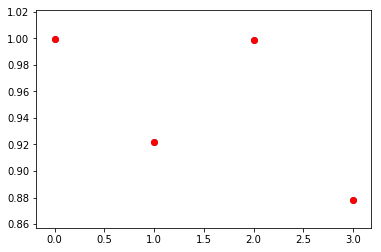

In [72]:
x = list(range(len(my_out)))
plt.scatter(x, my_out)
plt.scatter(x, out, color='r')
plt.show()


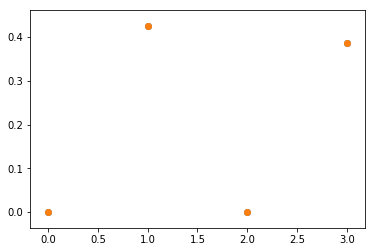

In [73]:
x = list(range(len(my_cost)))
plt.scatter(x, my_cost)
plt.scatter(x, cost_arr)
plt.show()

In [75]:
my_cost == cost_arr

0    True
2    True
1    True
3    True
Name: y, dtype: bool

In [62]:
X.values.dot(theta)

array([ 8.83388329,  2.46733499,  6.72265816,  1.97773671], dtype=float32)

In [63]:
X.values

array([[ 13.2335968 ,   4.43416882],
       [  6.71336794,  -1.77869785],
       [  7.12713623,   6.31818056],
       [  8.43808556,  -4.48261213]], dtype=float32)

In [24]:
(7.93563604 + 5.08651495)/2.0

6.511075495

In [25]:
theta

array([ 0.5,  0.5], dtype=float32)

In [26]:
out

array([ 0.9384653 ,  0.99787712,  0.99965572,  0.84782028], dtype=float32)

In [27]:
my_out.reshape((my_out.size, )) == out

array([ True,  True,  True,  True], dtype=bool)

In [28]:
out == my_out

array([ True,  True,  True,  True], dtype=bool)

In [101]:
# ok now let's check the gradient stuff
def grad(X, theta, y):
    diff = y - sig(X, theta)
    g = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j  in range(X.shape[1]):
            g[i,j] = diff[i] * X[i,j]
    return g

In [30]:
y

3    0.0
1    1.0
0    1.0
2    0.0
Name: y, dtype: float32

In [31]:
theta = theta.reshape((theta.size,))
grad(X.values, theta, y.values), sig(X.values, theta), y.values

(array([[ -8.38373756e+00,   3.26977110e+00],
        [  1.01601668e-02,   1.59633141e-02],
        [  3.69165326e-03,   1.79856387e-03],
        [ -6.21374750e+00,   3.30130386e+00]]),
 array([ 0.9384653 ,  0.99787712,  0.99965572,  0.84782028], dtype=float32),
 array([ 0.,  1.,  1.,  0.], dtype=float32))

In [32]:
gradient = np.zeros(shape=X.shape, dtype=np.float32)


In [33]:
X_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=X.values)
y_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=y.values)
theta_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=theta)
grad_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_WRITE | pcl.mem_flags.COPY_HOST_PTR , hostbuf=gradient)

In [34]:
grad_event = programs.logistic_gradient_ols(queue,
                                            X.shape,
                                            None,
                                            X_buf,
                                            theta_buf,
                                            y_buf,
                                            grad_buf,
                                            nrows,
                                            ncols)

In [35]:
gradient

array([[ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.],
       [ 0.,  0.]], dtype=float32)

In [36]:
grad_event.wait()

In [37]:
pcl.enqueue_copy(queue, gradient, grad_buf).wait()

In [38]:
gradient

array([[ -8.38373756e+00,   3.26977110e+00],
       [  1.01601668e-02,   1.59633141e-02],
       [  3.69165326e-03,   1.79856387e-03],
       [ -6.21374750e+00,   3.30130386e+00]], dtype=float32)

In [39]:
gradient == grad(X.values, theta, y.values)

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True]], dtype=bool)

In [40]:
gradient

array([[ -8.38373756e+00,   3.26977110e+00],
       [  1.01601668e-02,   1.59633141e-02],
       [  3.69165326e-03,   1.79856387e-03],
       [ -6.21374750e+00,   3.30130386e+00]], dtype=float32)

In [85]:
grad(X.values, theta, y.values)

array([[  1.92778767e-03,   6.45941996e-04],
       [ -6.18851614e+00,   1.63963902e+00],
       [  8.56587756e-03,   7.59361917e-03],
       [ -7.41234922e+00,   3.93770432e+00]])

In [42]:
# let's double check I can get this to work

In [107]:
def fit_params(X, y, theta):
    tol = 1e-5
    learning_rate = 1e-2
    for i in range(0, 1000):
        my_est = sig(X, theta)
        my_cost = cost(my_est, y)
        my_cost = my_cost.sum()
        my_cost /= 2.
        if my_cost < tol:
            break
        else:
            my_gradient = grad(X, theta, y)
            my_gradient = my_gradient.mean(axis=0)
            theta = theta + learning_rate * my_gradient
            
    return theta

In [125]:
new_t = np.random.normal(size=theta.shape)
fitted_theta = fit_params(X.values, y.values, new_t)

In [126]:
fitted_theta

array([-0.14121078,  1.35125726])

In [127]:
cost(sig(X.values, fitted_theta), y).sum()

0.00070021012826479727

In [128]:
cost(sig(X.values, np.random.normal(size=theta.shape)), y).sum()

0.9950057140519678

In [138]:
# ok that works, let's see if I can get this to work with the gpu code
def fit_gpu(X, y, theta, queue, cntx):
    tol = 1e-5
    learning_rate = 1e-2
    nrows = np.int32(X.shape[0])
    ncols = np.int32(X.shape[1])
    for i in range(0, 1000):
        cost_arr = np.zeros(shape=(X.shape[0],), dtype=np.float32)
        X_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=X)
        y_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=y)
        theta_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_ONLY | pcl.mem_flags.COPY_HOST_PTR, hostbuf=theta)
        cost_buf = pcl.Buffer(cntx, pcl.mem_flags.READ_WRITE | pcl.mem_flags.COPY_HOST_PTR, hostbuf=cost_arr)
        
        cost_event = programs.logistic_cost_ols(queue,X.shape,None,X_buf,theta_buf, y_buf,cost_buf,nrows,ncols)
        cost_event.wait()
        pcl.enqueue_copy(queue, cost_arr, cost_buf)
        cost_arr = cost_arr.sum()
        cost_arr /= 2.
        if cost_arr < tol:
            break
        else:
            grad_buf = pcl.Buffer(cntx, pcl.mem_flags.WRITE_ONLY , size=X.nbytes)
            grad_event = programs.logistic_gradient_ols(queue,X.shape,None,X_buf,theta_buf,y_buf,grad_buf,nrows,ncols)
            grad_event.wait()
            grad_arr = np.zeros(shape=X.shape, dtype=np.float32)
            pcl.enqueue_copy(queue, grad_arr, grad_buf)
            grad_arr = grad_arr.mean(axis=0)
            theta = theta + learning_rate * grad_arr
            
    return theta
            
            
        
        
        

In [145]:
new_t = np.random.normal(size=theta.shape).astype(np.float32)
fitted_t_gpu = fit_gpu(X.values, y.values, new_t, queue, cntx)

0.499499440193
0.49914765358
0.498549252748
0.49753344059
0.495814412832
0.492922097445
0.488103508949
0.480207592249
0.467612147331
0.448338031769
0.420562714338
0.383552759886
0.3384334445
0.288002938032
0.236046388745
0.187085539103
0.145481690764
0.113489128649
0.0906126797199
0.0748503878713
0.0640667527914
0.0565915554762
0.0512768924236
0.0473753325641
0.0444087833166
0.0420715771616
0.0401665046811
0.0385647676885
0.0371810495853
0.035957954824
0.0348563157022
0.033848952502
0.0329167544842
0.0320460088551
0.0312267541885
0.0304515827447
0.0297149177641
0.029012452811
0.0283407960087
0.0276972278953
0.0270795095712
0.0264857597649
0.0259143989533
0.0253640394658
0.0248334463686
0.0243215374649
0.023827329278
0.0233499165624
0.022888481617
0.0224422551692
0.0220105238259
0.0215926412493
0.0211879685521
0.0207959320396
0.0204159710556
0.020047577098
0.0196902602911
0.0193435586989
0.0190070271492
0.0186802484095
0.0183628369123
0.0180544164032
0.0177546348423
0.017463138327
0.017

In [146]:
fitted_t_gpu

array([-0.14194939,  1.35674989], dtype=float32)

In [147]:
fitted_theta = fit_params(X.values, y.values, new_t)

In [148]:
fitted_theta

array([-0.14194934,  1.35674932])

In [149]:
fitted_t_gpu - fitted_theta

array([ -4.57286920e-08,   5.71909325e-07])